---
# pRF experiment

This notebook contains an initial analysis of the pRF-data (run-2 and run-5). Each run had 3 iterations of the pRF-design, meaning we will average runs, and iterations.

In [296]:
from linescanning import utils,prf
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import os
opj = os.path.join

warnings.simplefilter('ignore')
project_dir = os.environ.get("DIR_PROJECTS")
base_dir = os.path.join(project_dir, 'hemifield')
deriv_dir = opj(base_dir, 'derivatives')

plot_vox = 359

np.set_printoptions(precision=3)

Fetch the files representing the functional data (`bold.mat` > `call_linerecon`), experiment log file `events.tsv` > `exptools2`), regressor file (`physio.txt`) and mat-file (`physio.mat`) physio files (`call_spmphysio`). `run_files` collects all these files in a list, from which we can then pick the required files and store them in their respective variable

In [128]:
# Load data
sub         = '003'
ses         = 3
task        = "task-pRF"
run         = [2,5]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
prf_dir     = opj(base_dir, 'derivatives', 'prf', f"sub-{sub}", f"ses-{ses}")

if not os.path.exists(prf_dir):
    os.makedirs(prf_dir, exist_ok=True)

In [ ]:
run_files = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir)
func_file   = utils.get_file_from_substring("bold.mat", run_files)
print(func_file)

window = 19
order = 3

## window 5 TR poly 2
func = utils.ParseFuncFile(func_file, 
                           subject=1,
                           deleted_first_timepoints=0, 
                           deleted_last_timepoints=0,
                           window_size=window, # needs to be odd
                           high_pass=True,
                           poly_order=order)

avg_func = func.df_func_psc.groupby(['subject', 't']).mean()
print(avg_func.shape)
avg_func.head()

win11_poly3 = avg_func.copy()

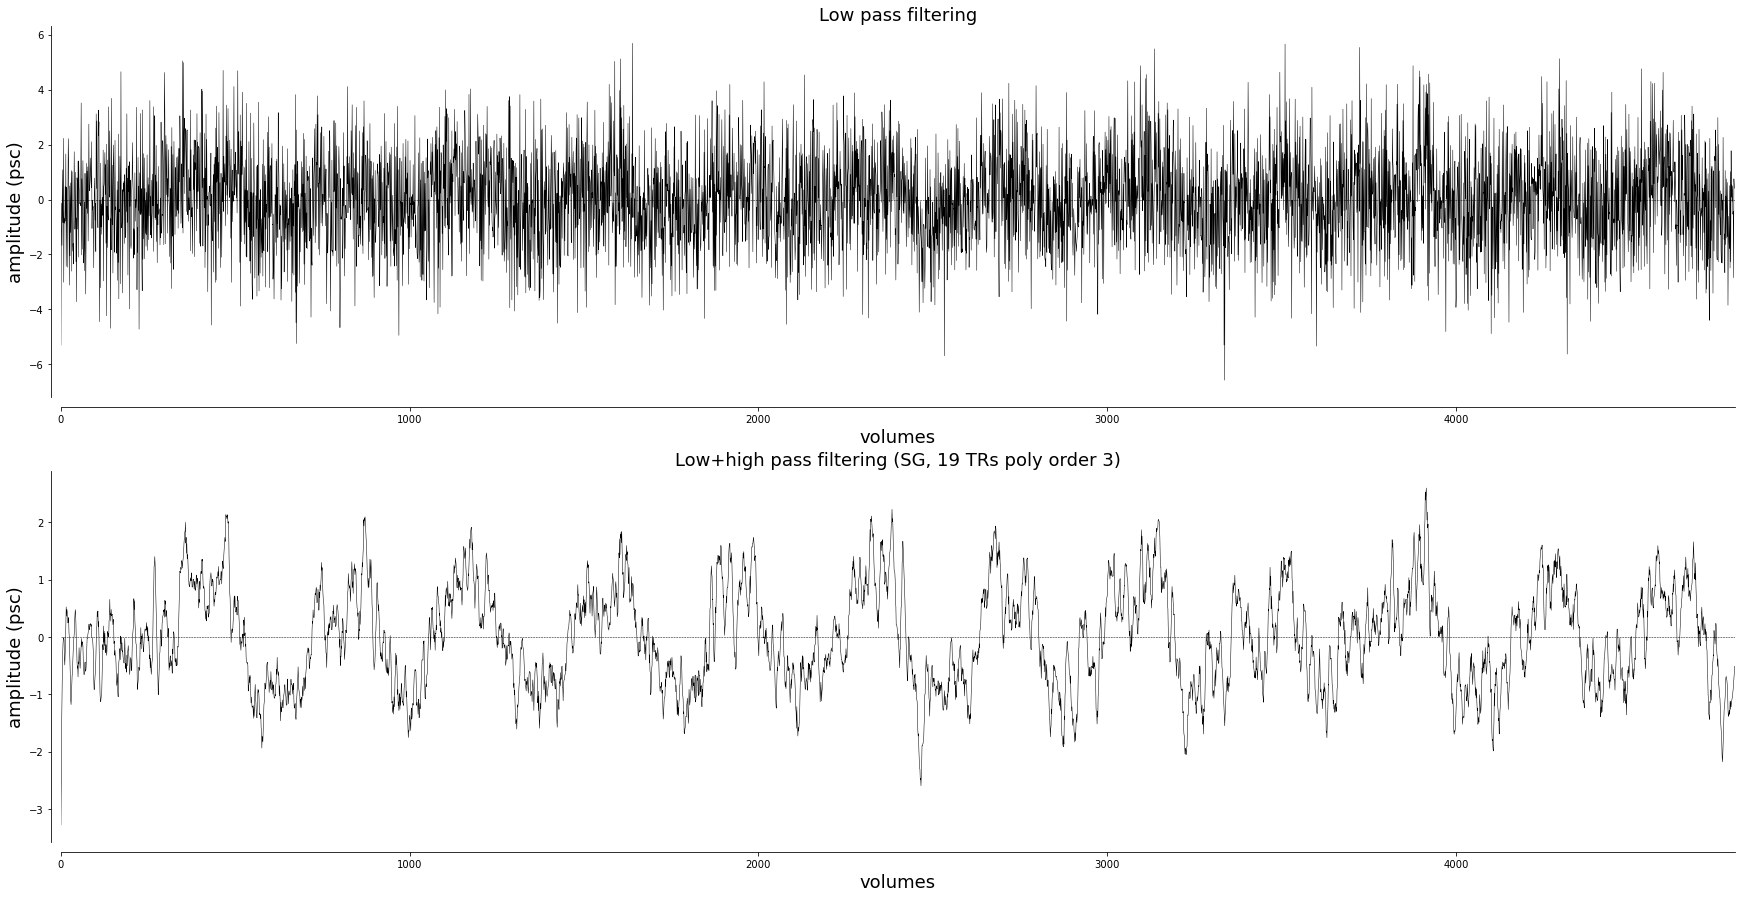

In [88]:
# use this setup so we can add the shaded boxes
fig,axs = plt.subplots(2,1, figsize=(30,15))

# timecourse
utils.LazyPlot(func.low_passed_df[f'vox {plot_vox}'].values,
               axs=axs[0],
               line_width=0.5,
               color="#000000",
               x_label="volumes",
               title="Low pass filtering",
               y_label="amplitude (psc)",
               add_hline='default',
               sns_trim=False,
               x_lim=[0,avg_func[f'vox {plot_vox}'].values.shape[0]],
               font_size=18)

utils.LazyPlot(win11_poly3[f'vox {plot_vox}'].values,
               axs=axs[1],
               line_width=0.5,
               color="#000000",
               x_label="volumes",
               title=f"Low+high pass filtering (SG, {window} TRs poly order {order})",
               y_label="amplitude (psc)",
               add_hline='default',
               sns_trim=False,
               x_lim=[0,avg_func[f'vox {plot_vox}'].values.shape[0]],
               font_size=18)               

fig.savefig(opj(func_dir, "filtering.pdf"))

Here we start to chunk up the average timecourse into the individual iterations:
- $baseline_{tr} = 30s / 0.105s \approx 285.71 $ trials. Because we're dealing with volumes and TRs, we need an integer, so let's say $286$
- Each iteration = $160$ seconds, so $160/0.25 \approx 1523.81$ trials. Again, make integer: $1524$ trials per iteration
- We have three iterations, but for some reason the number of trials exceeded the number of volumes (timing of the sequence seems difficult to predict with multi-echo acquisition..?)
- Now I loop through the number of iterations starting from $286$ with steps of $1524$.
- The final iteration doesn't have enough volumes for this operation, so it's zero-padded at the end
- The output of this is a numpy-array with shape `(1524, 720, 3)` for `(<volumes>, <n_voxels>, <iterations>)`, which is then concatenated over the last axis

Q: what to do about the baseline? There's no average for baseline, so if we add the baseline back after averaging we have a rather tumultuous beginning of the timecourse followed by smoother timecourse due to averaging

In [89]:
n_iter = 3
iter_chunks = []
start = 286
iter_size = 1524
baseline = avg_func[:start]
for ii in range(n_iter):

    
    # try to fetch values, if steps are out of bounds, zero-pad the timecourse
    if start+iter_size < avg_func.shape[0]:
        chunk = avg_func.values[start:start+iter_size]
    else:
        chunk = avg_func.values[start+iter_size:]
        padded_array = np.zeros((iter_size, 720))
        padded_array[:chunk.shape[0]] = chunk
        chunk = padded_array.copy()

    iter_chunks.append(chunk[...,np.newaxis])
    start += iter_size
    print(f"Chunk size = {chunk.shape}")

avg_iters_baseline = np.concatenate((baseline, np.concatenate(iter_chunks, axis=-1).mean(axis=-1)))
avg_iters_no_baseline = np.concatenate(iter_chunks, axis=-1).mean(axis=-1)
print(f"Final func data (w/o baseline) has shape: {avg_iters_no_baseline.shape}")

Chunk size = (1524, 720)
Chunk size = (1524, 720)
Chunk size = (1524, 720)
Final func data (w/o baseline) has shape: (1524, 720)


Here I plotted the average timecourse with the iterations marked in shaded bands

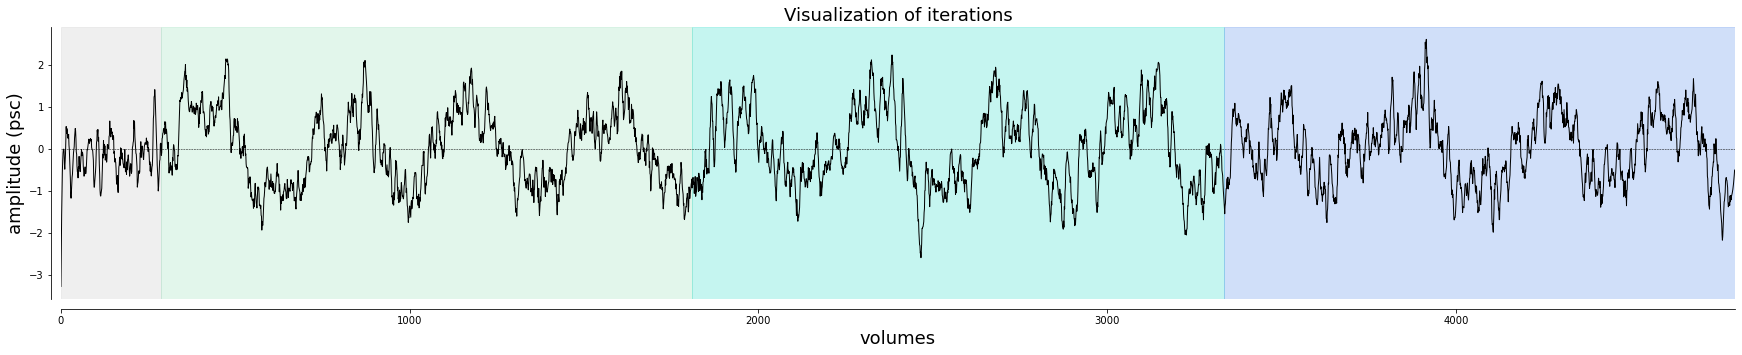

In [93]:
# use this setup so we can add the shaded boxes
fig,axs = plt.subplots(figsize=(30,5))
x = np.arange(0, len(avg_func[f'vox {plot_vox}'].values), step=1)

# shaded boxes for iterations
axs.axvspan(0, 286, alpha=0.3, color="#cccccc")
axs.axvspan(286, 286+iter_size, alpha=0.3, color="#9FE2BF")
axs.axvspan(286+iter_size, 286+(iter_size*2), alpha=0.3, color="#40E0D0")
axs.axvspan(286+(iter_size*2), avg_func.shape[0], alpha=0.3, color="#6495ED")

# timecourse
utils.LazyPlot(avg_func[f'vox {plot_vox}'].values,
               axs=axs,
               line_width=1,
               color="#000000",
               x_label="volumes",
               title="Visualization of iterations",
               y_label="amplitude (psc)",
               add_hline='default',
               sns_trim=False,
               x_lim=[0,avg_func[f'vox {plot_vox}'].values.shape[0]],
               font_size=18)

fig.savefig(opj(func_dir, "clustering.pdf"))

Below the averaged timecourses across the cortical ribbon at our target vertex without adding back the baseline

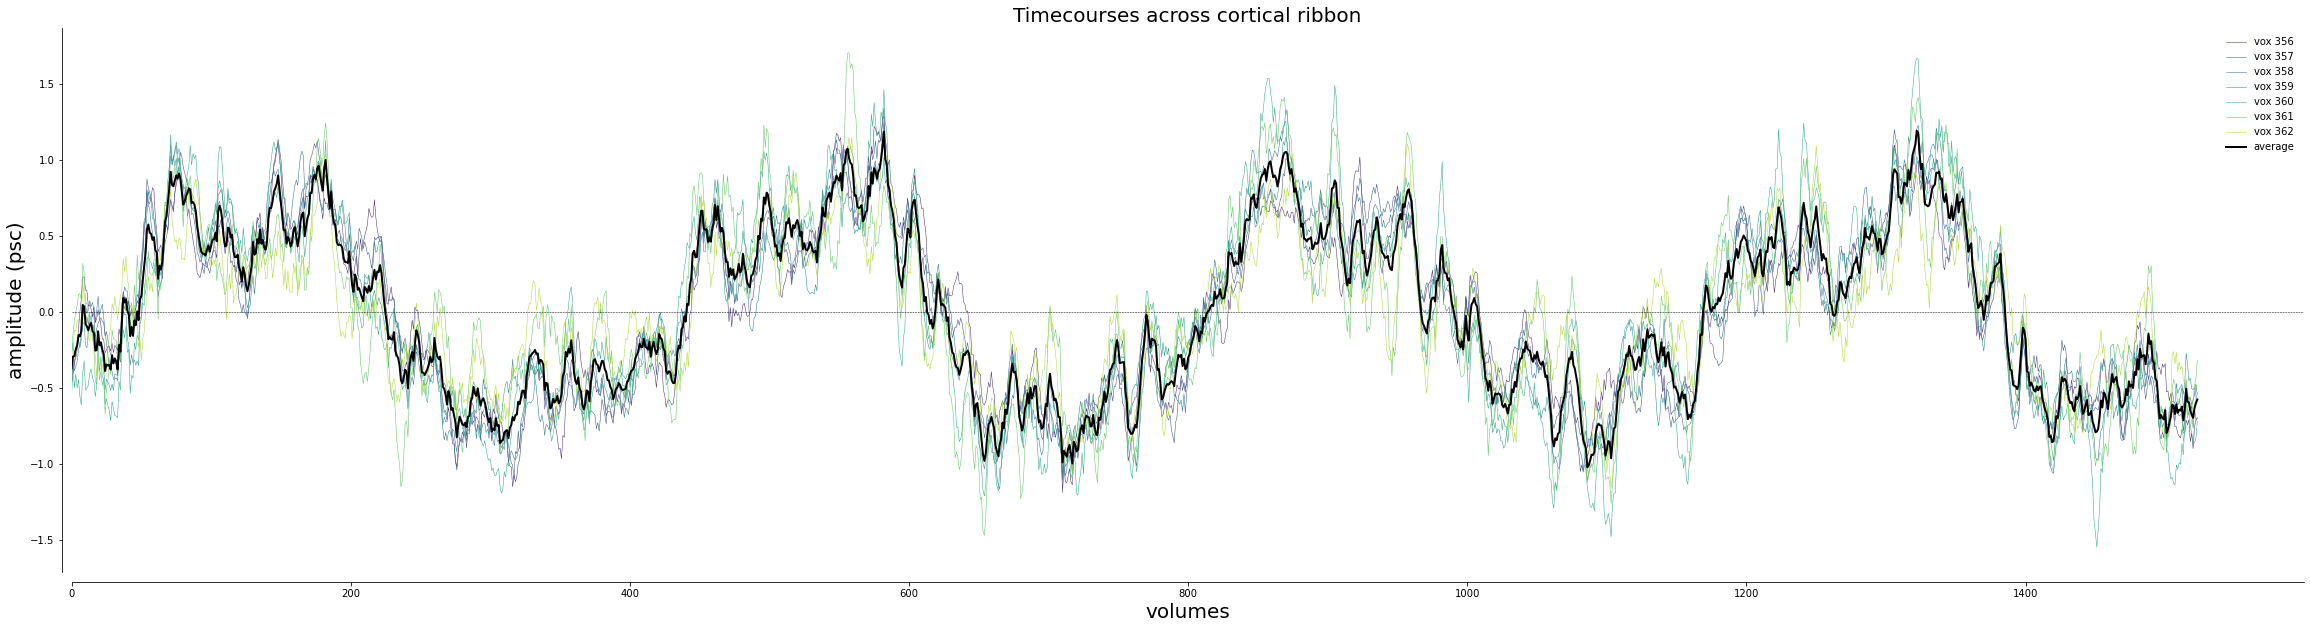

In [92]:
fig,axs = plt.subplots(figsize=(40,10))

ribbon      = [356,363]
include_vox = np.arange(*ribbon)
data = [avg_iters_no_baseline[:, ii] for ii in include_vox]

# get average across depth w/ different color
avg_ribbon = [ii[...,np.newaxis] for ii in data]
avg_ribbon = np.concatenate(avg_ribbon, axis=-1).mean(axis=-1)

labels = [f'vox {ii}' for ii in include_vox]

# plot individual voxels
utils.LazyPlot(data,
               axs=axs,
               x_label="volumes",
               y_label="amplitude (psc)",
               title="Timecourses across cortical ribbon",
               labels=labels,
               add_hline='default',
               set_xlim_zero=True,
               sns_trim=False,
               line_width=0.5,
               font_size=20)

# plot average
utils.LazyPlot(avg_ribbon,
               axs=axs,
               color="#000000",
               labels='average',
               set_xlim_zero=True,
               sns_trim=False,
               line_width=2,
               font_size=20)

fig.savefig(opj(func_dir, "avg+ribbon.pdf"))

What to do about the baseline.. This is not average over iterations, only over the two pRF-runs.. So adding is back to the timecourse averaged over iterations looks a bit off..

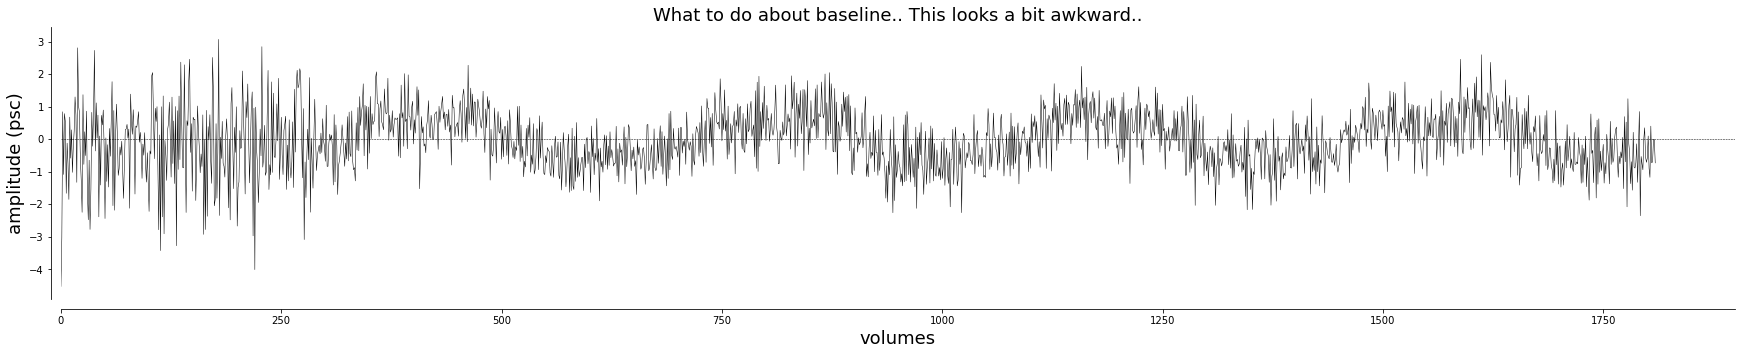

In [50]:
utils.LazyPlot(avg_iters_baseline[:, plot_vox],
               figsize=(30,5),
               line_width=0.5,
               color="#000000",
               x_label="volumes",
               y_label="amplitude (psc)",
               title="What to do about baseline.. This looks a bit awkward..",
               add_hline='default',
               sns_trim=False,
               set_xlim_zero=True,
               font_size=18)

add data to `pRF`-key

In [44]:
hdf_file = opj(func_dir, 'sub-003_ses-3_bold1.h5')
if not os.path.exists(hdf_file):
    func.to_hdf('df_func_psc', hdf_file, 'pRF')

---
# pRF-fitting

Here we fetch relevant pRF-parameters that are required to construct the size-response curve below (this is the same curve as in `derivatives/pycortex/<subject>/<subject>_hemi-?_desc-prf_sizeresponse.pdf`).

In [211]:
# collect subject data including Normalization parameters
cx_dir = opj(project_dir, 'hemifield', 'derivatives', 'pycortex', f"sub-{sub}")
prf_dir = opj(project_dir, 'hemifield', 'derivatives', 'prf', f"sub-{sub}", 'ses-1')
subject_info = utils.CollectSubject(f"sub-{sub}", 
                                    prf_dir=prf_dir, 
                                    cx_dir=cx_dir, 
                                    settings='recent', 
                                    hemi="lh", 
                                    model="norm")

# initiate the SizeResponse class
SR = prf.SizeResponse(subject_info.prf_stim, subject_info.normalization_params, subject_info=subject_info)

# make the stimuli
SR.make_stimuli()

# make the curve
sr_curve1 = SR.make_sr_function(center_prf=True)

# stimsizes are in SR.stims_fill_sizes

Using settings file: /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-1/20220210_model-norm_desc-settings.yml


1


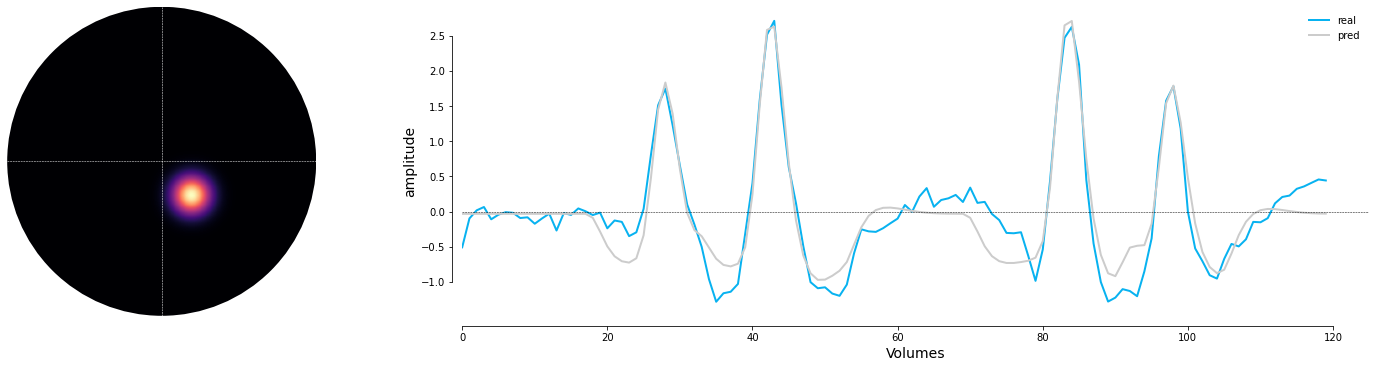

In [212]:
subject_info.target_prediction_prf()

Create the design matrix

In [125]:
design = prf.create_line_prf_matrix(log_dir, 
                                    nr_trs=avg_iters_baseline.shape[0],
                                    TR=0.105,
                                    n_pix=270)

In [126]:
design = design[...,286:]
design.shape

(270, 270, 1524)

Define the fitter; use update screen distance size

In [130]:
avg_func.shape

(4800, 720)

In [133]:
func = np.array(data)
modelling = prf.pRFmodelFitting(func, 
                                design_matrix=design, 
                                TR=0.105, 
                                model='norm', 
                                stage='grid+iter', 
                                verbose=True, 
                                output_dir=prf_dir,
                                output_base="sub-003_ses-3_task-pRF",
                                write_files=True)

modelling.fit()

Starting gauss grid fit at 2022/02/14 18:25:53
Gaussian gridfit completed at 2022/02/14 18:26:48. voxels/vertices above 0.1: 7 out of 7
Gridfit took 0:00:54.417868
Mean rsq>0.1: 0.6467800225530352
Save grid-fit parameters in /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-3/sub-003_ses-3_task-pRF_model-gauss_stage-grid_desc-prf_params.npy
Starting gauss iterfit at 2022/02/14 18:26:48
Gaussian iterfit completed at 2022/02/14 18:26:58. Mean rsq>0.1: 0.6467800340581565
Iterfit took 0:00:09.912216
Save iter-fit parameters in /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-3/sub-003_ses-3_task-pRF_model-gauss_stage-iter_desc-prf_params.npy
Using settings file: /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-3/20220214_model-norm_desc-settings.yml
Starting norm grid fit at 2022/02/14 18:26:58


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   19.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   19.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   19.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   19.5s finished


Norm gridfit completed at 2022/02/14 18:27:18. Mean rsq>0.1: 0.7588321822030204
Gridfit took 0:00:19.527027
Save grid-fit parameters in /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-3/sub-003_ses-3_task-pRF_model-norm_stage-grid_desc-prf_params.npy
Starting norm iterfit at 2022/02/14 18:27:18
Norm iterfit completed at 2022/02/14 19:12:19. Mean rsq>0.1: 0.7640328473764105
Iterfit took 0:45:01.221319
Save iter-fit parameters in /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/prf/sub-003/ses-3/sub-003_ses-3_task-pRF_model-norm_stage-iter_desc-prf_params.npy


In [156]:
data[0].shape

(1524,)

In [148]:
norm_predictions = np.zeros_like(func)
for ii in range(func.shape[0]):
    norm_predictions[ii,...] = modelling.norm_model.return_prediction(*modelling.norm_iter[ii,:-1])

norm_predictions.shape

(7, 1524)

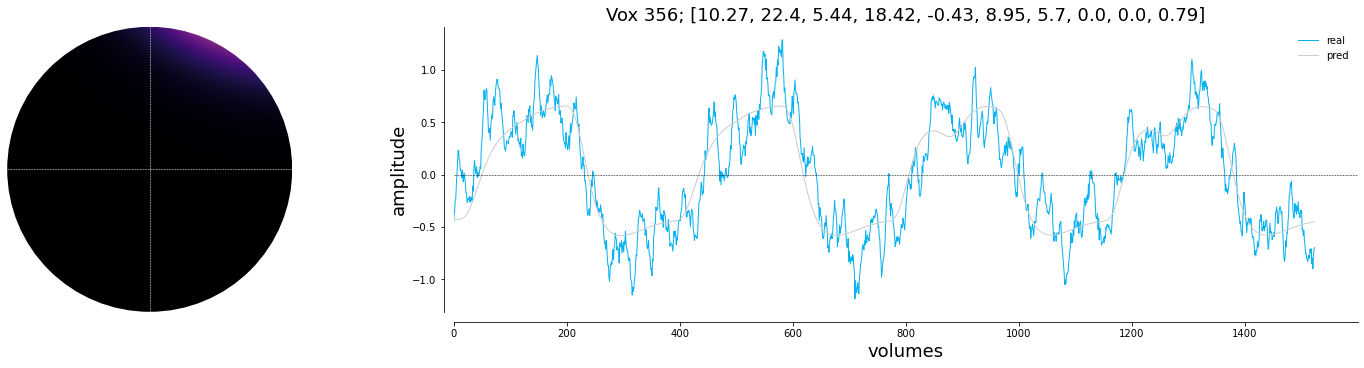

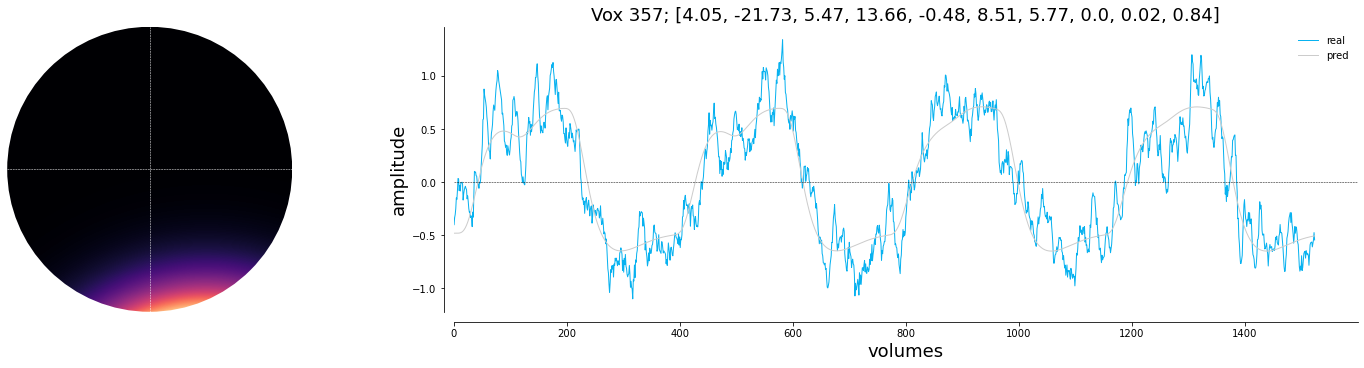

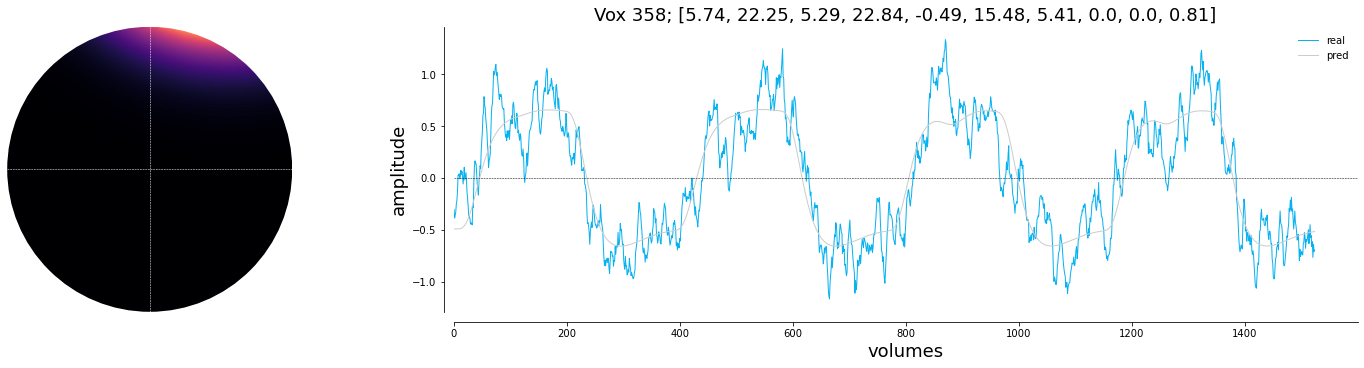

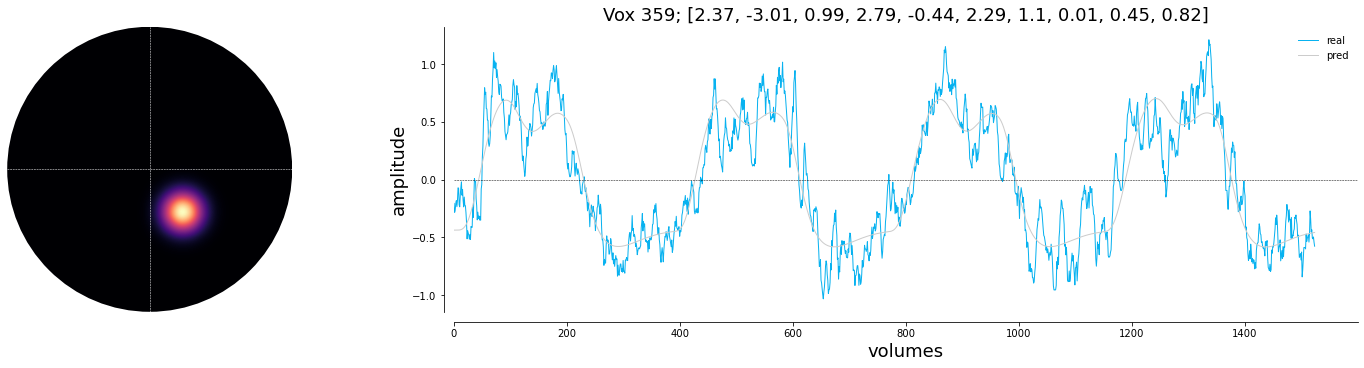

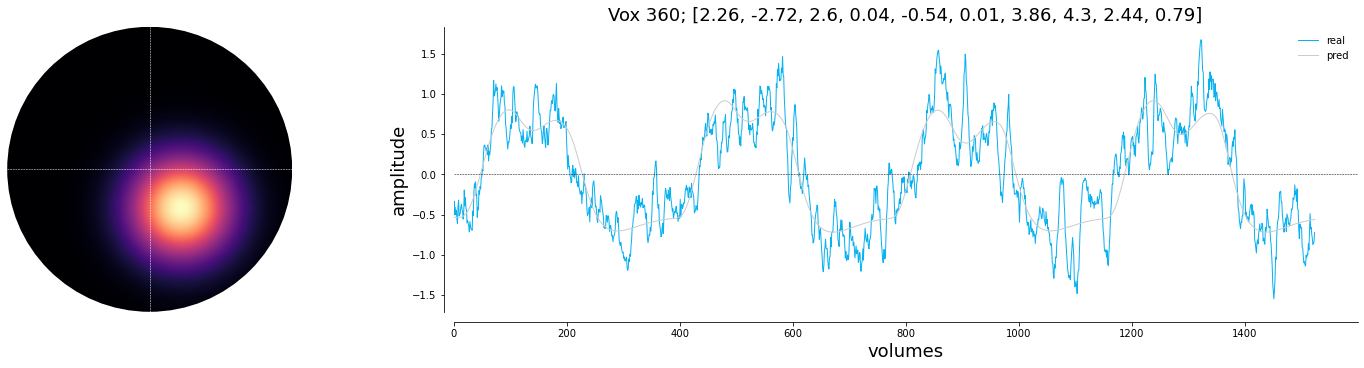

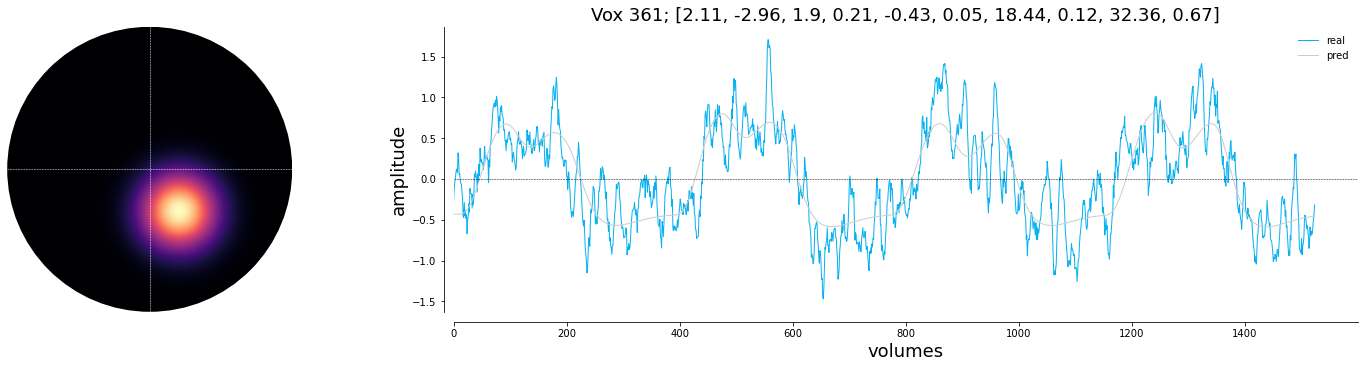

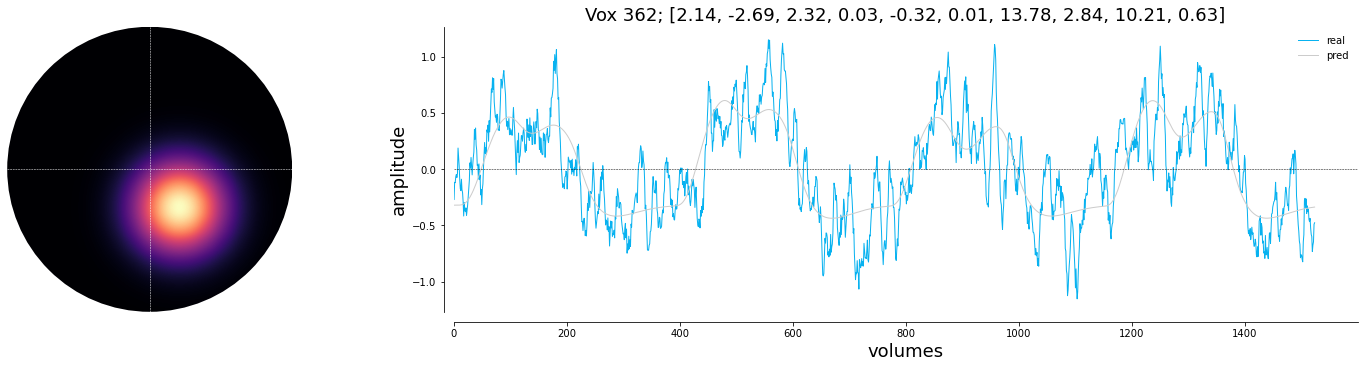

In [219]:
for vox_id in range(norm_predictions.shape[0]):
    
    fig = plt.figure(constrained_layout=True, figsize=(20,5))
    gs00 = fig.add_gridspec(1,2, width_ratios=[10,20])

    pars = modelling.norm_iter[vox_id,...]
    ax1 = fig.add_subplot(gs00[0])
    prf_array = prf.make_prf(modelling.prf_stim, size=pars[2], mu_x=pars[0], mu_y=pars[1])
    prf.plot_prf(prf_array, subject_info.settings['vf_extent'], ax=ax1)

    ax2 = fig.add_subplot(gs00[1])
    utils.LazyPlot([data[vox_id], norm_predictions[vox_id,...]],
                axs=ax2,
                x_label="volumes",
                y_label="amplitude",
                color=['#08B2F0','#cccccc'], 
                labels=['real','pred'],                
                title=f"Vox {include_vox[vox_id]}; {[round(ii, 2) for ii in modelling.norm_iter[vox_id,...]]}",
                add_hline='default',
                set_xlim_zero=True,
                sns_trim=False,
                font_size=18)

Session 1 - pRF prediction/location:

1


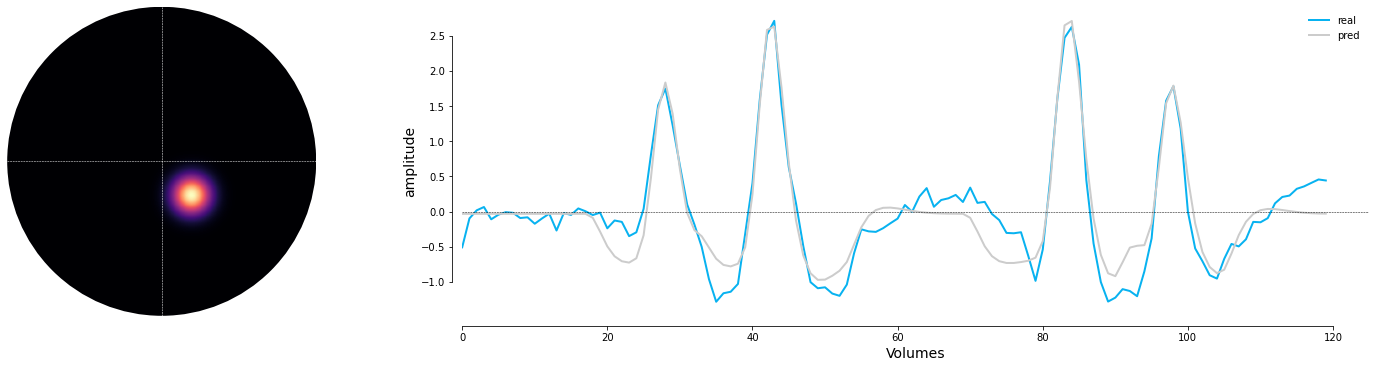

In [215]:
subject_info.target_prediction_prf()

`Vox 359` looks rather similar compared to our target vertex, which is sort of what we wanted. Below I created binary representations of both pRFs for an overlap image

Distance of centers between target pRF and line PRF = 1.06


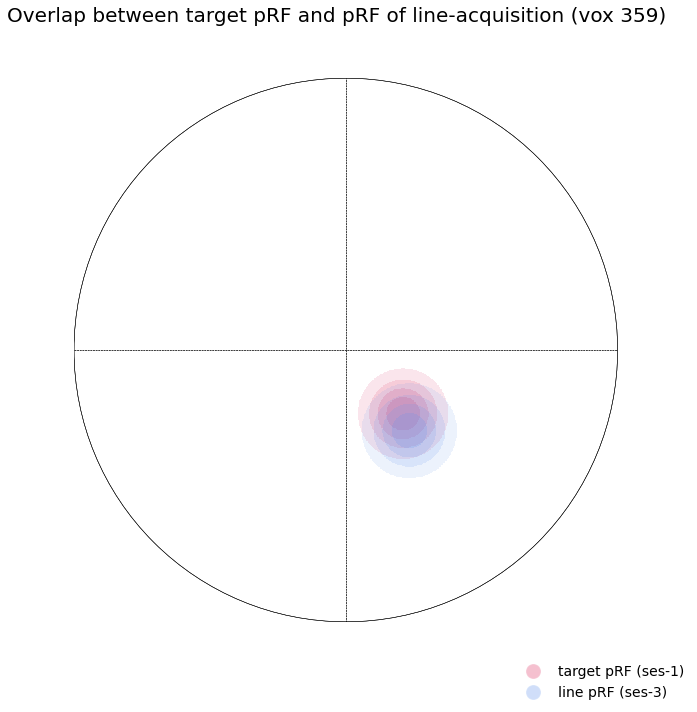

In [327]:
# get linescanning pRF 
vox_id = utils.find_nearest(include_vox, plot_vox)[0]
pars = modelling.norm_iter[vox_id,...]
prf_line = prf.make_prf(modelling.prf_stim, size=pars[2], mu_x=pars[0], mu_y=pars[1])

# get target pRF from ses-1
prf_target = subject_info.prf_array.copy()

# create different colormaps
colors = ["#DE3163", "#6495ED"]
cmap1 = utils.make_binary_cm(colors[0])
cmap2 = utils.make_binary_cm(colors[1])

# initiate and plot figure
fig,axs = plt.subplots(figsize=(10,10))
prf.plot_prf(prf_target, vf_extent=subject_info.settings['vf_extent'], ax=axs, cmap=cmap1, cross_color='k', alpha=0.5)
prf.plot_prf(prf_line, vf_extent=subject_info.settings['vf_extent'], ax=axs, cmap=cmap2, cross_color='k', alpha=0.5)

# get distance of pRF-centers
dist = prf.distance_centers(subject_info.target_params, pars)
print(f"Distance of centers between target pRF and line PRF = {round(dist, 2)}")

# create custom legend
legend_elements = [Line2D([0],[0], marker='o', color='w', label='target pRF (ses-1)', mfc=colors[0], markersize=15, alpha=0.3),
                   Line2D([0],[0], marker='o', color='w', label='line pRF (ses-3)', mfc=colors[1], markersize=15, alpha=0.3)]
                   
fig.legend(handles=legend_elements, frameon=False, fontsize=14, loc='lower right')

# overarching title
fig.suptitle(f"Overlap between target pRF and pRF of line-acquisition (vox {plot_vox})", fontsize=20)

# save img
img = opj(deriv_dir, 'prf', 'sub-003', 'ses-3', 'prf_overlap.pdf')
fig.savefig(img)